In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os

In [2]:
def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow

my_seed = 42
my_seed_everywhere(my_seed)

In [3]:
df = pd.read_csv('/content/sample_data/radish_final.csv', index_col=0)
df = df.dropna(axis=0)
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [4]:
df = df.drop(['Temp'],axis=1)
df = df.drop(['Oil'],axis=1)
df = df.drop(['Sup'],axis=1)
df = df.drop(['Avg_Price'], axis=1)

df['DayOfWeek'] = df['DayOfWeek'].astype('category')
df = pd.get_dummies(df, columns =['DayOfWeek'], prefix='W', drop_first=True)

df.tail()

,Date,Rain,Wind,sobimul,nongmul,Price,Produced,W_1,W_2,W_3,W_4
2390,2022-09-26,0.0,1.7,2.5,8.7,3714.0,1172345,0,0,0,0
2391,2022-09-27,0.0,1.6,2.5,8.7,3782.0,1172345,1,0,0,0
2392,2022-09-28,0.0,1.8,2.5,8.7,3782.0,1172345,0,1,0,0
2393,2022-09-29,0.0,1.4,2.5,8.7,3920.0,1172345,0,0,1,0
2394,2022-09-30,0.0,1.6,2.5,8.7,3970.0,1172345,0,0,0,1


In [5]:
from sklearn.preprocessing import MinMaxScaler
input_indicator = df.loc[:,['Rain', 'Wind', 'sobimul', 'nongmul', 'Produced', 'W_1', 'W_2', 'W_3', 'W_4']]
target_indicator = df.loc[:,['Price']].values[:]
scaler_input = MinMaxScaler()
scaler_target = MinMaxScaler()
scaled_input_indicator = scaler_input.fit_transform(input_indicator)
scaled_target_indicator = scaler_target.fit_transform(target_indicator) # 가격 관련 지표에 스케일링

x = np.concatenate((scaled_target_indicator, scaled_input_indicator), axis=1)
y = x[:, [0]]

print(x)
print(y.shape)

[[0.24351879 0.         0.61403509 ... 1.         0.         0.        ]
 [0.24876202 0.         0.36842105 ... 0.         1.         0.        ]
 [0.23507137 0.         0.19298246 ... 0.         0.         1.        ]
 ...
 [0.79667929 0.         0.19298246 ... 1.         0.         0.        ]
 [0.83687737 0.         0.12280702 ... 0.         1.         0.        ]
 [0.85144189 0.         0.15789474 ... 0.         0.         1.        ]]
(2395, 1)


In [6]:
# 21일치의 input으로 8일치의 output을 생산(API 문제상 당일날 input은 활용 불가능할 것으로 예상됨)
# 추후 train, validation, train set를 6년, 2년, 2년으로 나눠볼까 생각중, 지금은 many_to_many 코드 구현을 목표로 구현하지 않음
seq_length = 3
predict_day = 3
dataX = [] 
dataY = [] 
for i in range(0, int(len(y) - seq_length - predict_day)):
    _x = x[i : i + seq_length]
    _y = y[i + predict_day : i + seq_length + predict_day] 
    dataX.append(_x) 
    dataY.append(_y) 
print(len(dataX))
print(len(dataY))

2389
2389


In [7]:
# Train Set 생성, 추후 Validation, Test도 여기에다가 추가 예상됨, 또한 21의 배수로 설정해야 batch에서 오류가 발생하지 않음
train_size = 1431
validation_size = 477
test_size = 477

trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
validX = np.array(dataX[train_size:train_size+validation_size])
validY = np.array(dataY[train_size:train_size+validation_size])
testX = np.array(dataX[train_size+validation_size:train_size+validation_size+test_size])
testY = np.array(dataY[train_size+validation_size:train_size+validation_size+test_size])

print(trainX.shape)
print(trainY.shape)
print(validX.shape)
print(validY.shape)
print(testX.shape)
print(testY.shape)

(1431, 3, 10)
(1431, 3, 1)
(477, 3, 10)
(477, 3, 1)
(477, 3, 10)
(477, 3, 1)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Activation
from tensorflow import keras

In [9]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [10]:
input_columns = 10 # 데이터 셋의 '열' 개수 (dataX) / dataset's columns (dataX)

model = Sequential()
model.add(LSTM(16, batch_input_shape=(3, 3, input_columns), return_sequences=True, stateful=True, dropout=0.1))
model.add(LSTM(16, return_sequences=True, stateful=True, dropout=0.1))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (3, 3, 16)                1728      
                                                                 
 lstm_1 (LSTM)               (3, 3, 16)                2112      
                                                                 
 dense (Dense)               (3, 3, 1)                 17        
                                                                 
Total params: 3,857
Trainable params: 3,857
Non-trainable params: 0
_________________________________________________________________


In [11]:
from tensorflow.keras.callbacks import EarlyStopping
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model-radish.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

In [12]:
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [13]:
custom_hist = CustomHistory()
custom_hist.init()

In [14]:
for epoch_idx in range(100):
  print('epochs:' + str(epoch_idx))
  hist = model.fit(trainX, trainY, validation_data=(validX, validY), epochs=1, batch_size=3, verbose=2, shuffle=False, callbacks=[checkpoint_cb, custom_hist, early_stopping_cb])
  model.reset_states()

epochs:0
477/477 - 10s - loss: 0.0200 - mae: 0.1018 - val_loss: 0.1028 - val_mae: 0.2901 - 10s/epoch - 22ms/step
epochs:1
477/477 - 2s - loss: 0.0202 - mae: 0.1121 - val_loss: 0.0859 - val_mae: 0.2700 - 2s/epoch - 4ms/step
epochs:2
477/477 - 2s - loss: 0.0142 - mae: 0.0922 - val_loss: 0.0577 - val_mae: 0.2243 - 2s/epoch - 5ms/step
epochs:3
477/477 - 2s - loss: 0.0102 - mae: 0.0750 - val_loss: 0.0420 - val_mae: 0.1931 - 2s/epoch - 5ms/step
epochs:4
477/477 - 2s - loss: 0.0088 - mae: 0.0671 - val_loss: 0.0353 - val_mae: 0.1783 - 2s/epoch - 4ms/step
epochs:5
477/477 - 2s - loss: 0.0081 - mae: 0.0635 - val_loss: 0.0348 - val_mae: 0.1777 - 2s/epoch - 4ms/step
epochs:6
477/477 - 2s - loss: 0.0070 - mae: 0.0592 - val_loss: 0.0213 - val_mae: 0.1382 - 2s/epoch - 5ms/step
epochs:7
477/477 - 2s - loss: 0.0068 - mae: 0.0569 - val_loss: 0.0253 - val_mae: 0.1509 - 2s/epoch - 5ms/step
epochs:8
477/477 - 2s - loss: 0.0068 - mae: 0.0574 - val_loss: 0.0219 - val_mae: 0.1404 - 2s/epoch - 4ms/step
epochs:

In [16]:
a = 3

In [17]:
model.evaluate(trainX, trainY, batch_size = a)

477/477 [==============================] - 1s 3ms/step - loss: 0.0027 - mae: 0.0414


[0.0027099272701889277, 0.04138224199414253]

In [18]:
print(custom_hist.train_loss)

[0.01998017728328705, 0.020233742892742157, 0.014184574596583843, 0.01016801968216896, 0.008786695078015327, 0.008125859312713146, 0.007007337640970945, 0.00675453245639801, 0.00679842010140419, 0.006392937619239092, 0.0057363142259418964, 0.005637355614453554, 0.005547252483665943, 0.005615574773401022, 0.005396118387579918, 0.004969791509211063, 0.004870687611401081, 0.004843173548579216, 0.004540824331343174, 0.004690260160714388, 0.004489294718950987, 0.004389879759401083, 0.003994287457317114, 0.0035914264153689146, 0.0034854973200708628, 0.0034535257145762444, 0.003353980602696538, 0.0030814409255981445, 0.0031058616004884243, 0.0029724303167313337, 0.002847149036824703, 0.0029977562371641397, 0.0027022564318031073, 0.0028330953791737556, 0.0026815941091626883, 0.0026922316756099463, 0.0026681385934352875, 0.0025765947066247463, 0.0027489904314279556, 0.0026640063151717186, 0.0025282828137278557, 0.0026936104986816645, 0.002610189840197563, 0.002468627877533436, 0.002525329357013

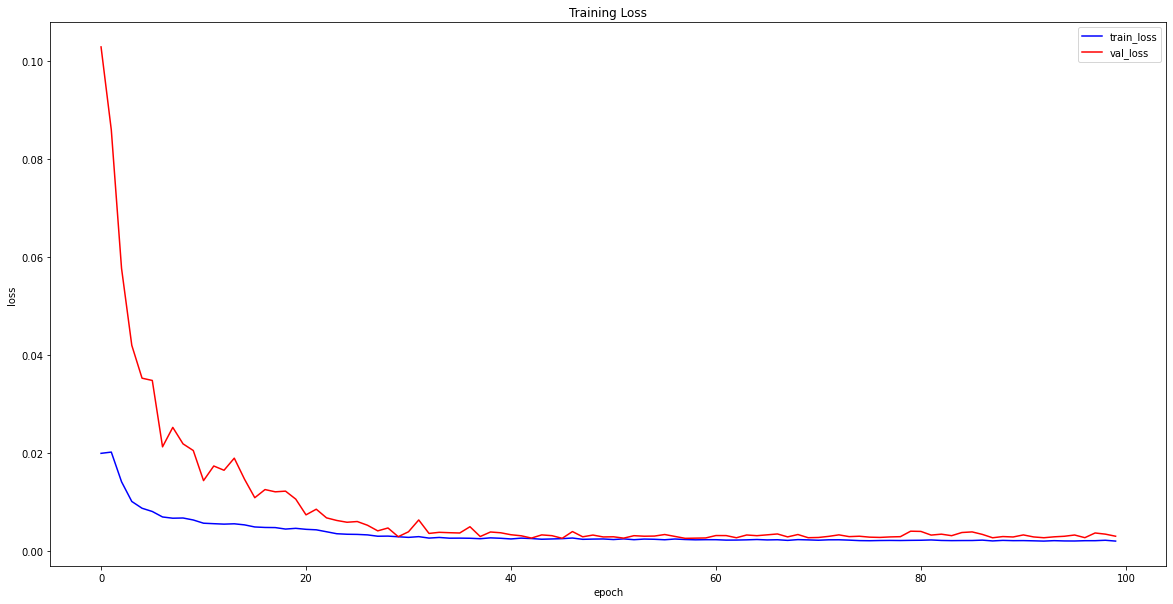

In [19]:
plt.figure(figsize=(20,10))
plt.plot(custom_hist.train_loss, color = 'blue', label = 'train_loss')
plt.plot(custom_hist.val_loss, color = 'red', label = 'val_loss')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [20]:
from keras.models import load_model
model = load_model('/content/best-model-radish.h5')

Train Data *평가*

In [21]:
model.evaluate(trainX, trainY, batch_size=a)

477/477 [==============================] - 2s 3ms/step - loss: 0.0026 - mae: 0.0402


[0.002553999423980713, 0.040215156972408295]

In [22]:
predicted_price_train = model.predict(trainX, batch_size=a, verbose=1) 

477/477 [==============================] - 2s 2ms/step


In [23]:
trainY_test = np.delete(trainY, np.s_[1:a], axis=1)
predicted_price_train_test = np.delete(predicted_price_train, np.s_[1:a], axis=1)

trainY_test = np.reshape(trainY_test, (1431, 1))
predicted_price_train_test = np.reshape(predicted_price_train_test, (1431, 1))
print(trainY_test.shape)
print(predicted_price_train_test.shape)

(1431, 1)
(1431, 1)


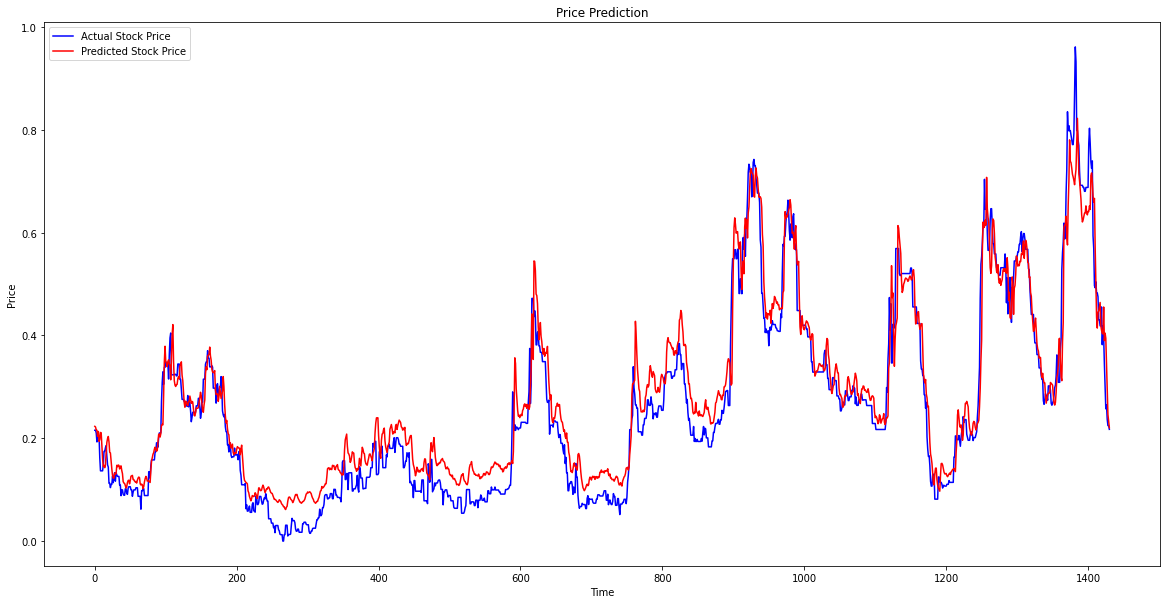

In [24]:
plt.figure(figsize=(20,10))
plt.plot(trainY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_train_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [25]:
predicted_price_train_test = np.reshape(predicted_price_train_test, (1431, ))
predicted_price_train_test = scaler_target.inverse_transform(predicted_price_train_test.reshape(-1,1))

print(predicted_price_train_test, predicted_price_train_test.shape)

trainY_test = scaler_target.inverse_transform(trainY_test.reshape(-1,1))

print(trainY_test, trainY_test.shape)

[[1813.0887]
 [1808.8407]
 [1789.2644]
 ...
 [1892.5416]
 [1848.4684]
 [1804.0425]] (1431, 1)
[[1787.]
 [1787.]
 [1769.]
 ...
 [1818.]
 [1818.]
 [1793.]] (1431, 1)


In [26]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(trainY_test, predicted_price_train_test) 
np.sqrt(MSE)

173.48646556792613

In [27]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(trainY_test, predicted_price_train_test)

138.02800366330362

Val Date 평가


In [28]:
model.evaluate(validX, validY, batch_size=a)

159/159 [==============================] - 0s 3ms/step - loss: 0.0027 - mae: 0.0408


[0.002654194599017501, 0.040824003517627716]

In [29]:
predicted_price_valid = model.predict(validX, batch_size=a, verbose=1) 

159/159 [==============================] - 0s 2ms/step


(477, 1)
(477, 1)


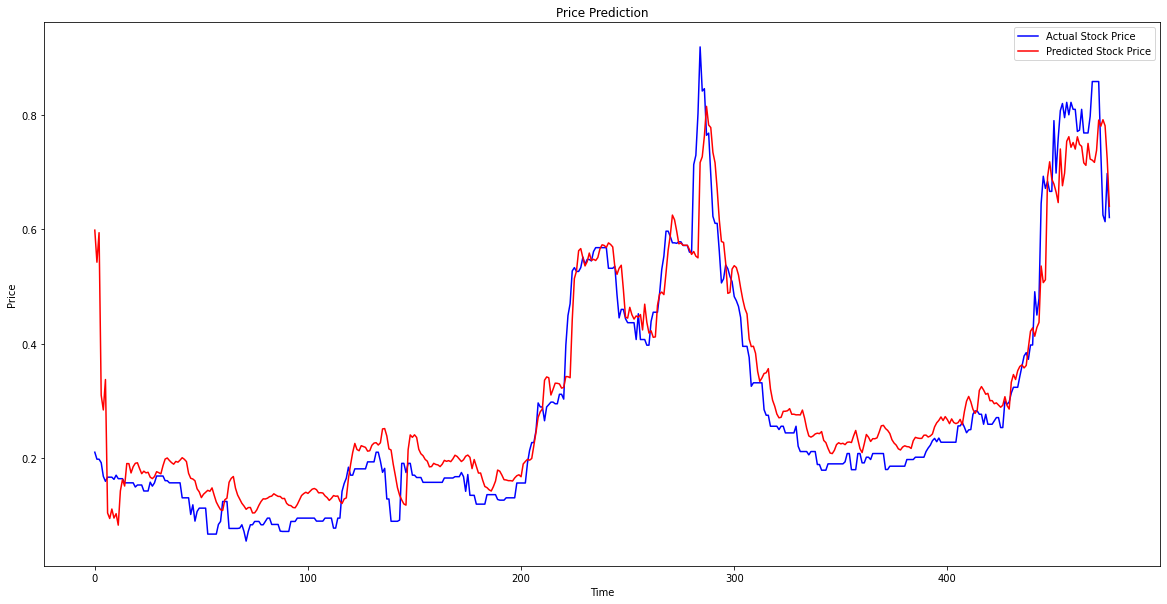

In [30]:
validY_test = np.delete(validY, np.s_[1:a], axis=1)
predicted_price_valid_test = np.delete(predicted_price_valid, np.s_[1:a], axis=1)

validY_test = np.reshape(validY_test, (477, 1))
predicted_price_valid_test = np.reshape(predicted_price_valid_test, (477, 1))
print(validY_test.shape)
print(predicted_price_valid_test.shape)

plt.figure(figsize=(20,10))
plt.plot(validY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_valid_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [31]:
predicted_price_valid_test = np.reshape(predicted_price_valid_test, (477, ))
predicted_price_valid_test = scaler_target.inverse_transform(predicted_price_valid_test.reshape(-1,1))

print(predicted_price_valid_test, predicted_price_valid_test.shape)

validY_test = scaler_target.inverse_transform(validY_test.reshape(-1,1))

print(validY_test, validY_test.shape)

[[3102.089 ]
 [2909.498 ]
 [3086.8545]
 [2110.2021]
 [2021.9312]
 [2204.709 ]
 [1402.8328]
 [1369.7825]
 [1426.6188]
 [1372.4417]
 [1398.5704]
 [1329.7948]
 [1535.4022]
 [1604.4623]
 [1564.7462]
 [1699.8429]
 [1699.1664]
 [1643.4327]
 [1680.9222]
 [1701.2976]
 [1704.5374]
 [1669.874 ]
 [1638.8934]
 [1654.0776]
 [1643.9572]
 [1647.5009]
 [1617.9664]
 [1609.3884]
 [1621.5935]
 [1651.0083]
 [1645.049 ]
 [1638.0924]
 [1687.2157]
 [1726.7585]
 [1733.342 ]
 [1718.3721]
 [1705.52  ]
 [1695.9484]
 [1712.6167]
 [1708.1133]
 [1720.3514]
 [1734.9728]
 [1725.5673]
 [1711.6537]
 [1640.9424]
 [1611.2917]
 [1607.0748]
 [1596.3496]
 [1548.0636]
 [1529.6682]
 [1495.2959]
 [1515.3779]
 [1527.5521]
 [1538.8955]
 [1533.3595]
 [1553.5874]
 [1509.8414]
 [1468.9463]
 [1443.9945]
 [1422.3865]
 [1418.1622]
 [1482.2659]
 [1492.0632]
 [1587.3903]
 [1610.8054]
 [1622.0996]
 [1552.2137]
 [1511.1093]
 [1485.9114]
 [1461.1855]
 [1444.6433]
 [1425.0614]
 [1435.357 ]
 [1435.8871]
 [1403.0804]
 [1403.6798]
 [1421.2557]

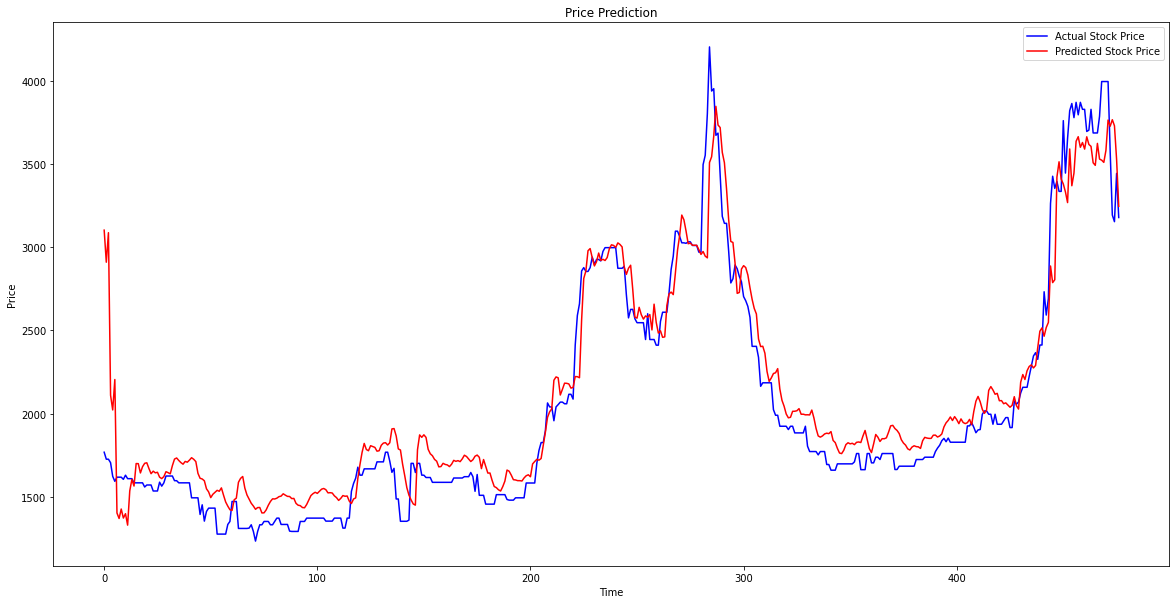

In [32]:
plt.figure(figsize=(20,10))
plt.plot(validY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_valid_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(validY_test, predicted_price_valid_test) 
np.sqrt(MSE)

208.98489072962946

In [34]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(validY_test, predicted_price_valid_test)

152.10026886178264

Test Data 평가

In [35]:
model.evaluate(testX, testY, batch_size=a)

159/159 [==============================] - 0s 3ms/step - loss: 0.0042 - mae: 0.0520


[0.004177647177129984, 0.05200831964612007]

In [36]:
predicted_price_test = model.predict(testX, batch_size=a, verbose=1)

159/159 [==============================] - 0s 2ms/step


(477, 1)
(477, 1)


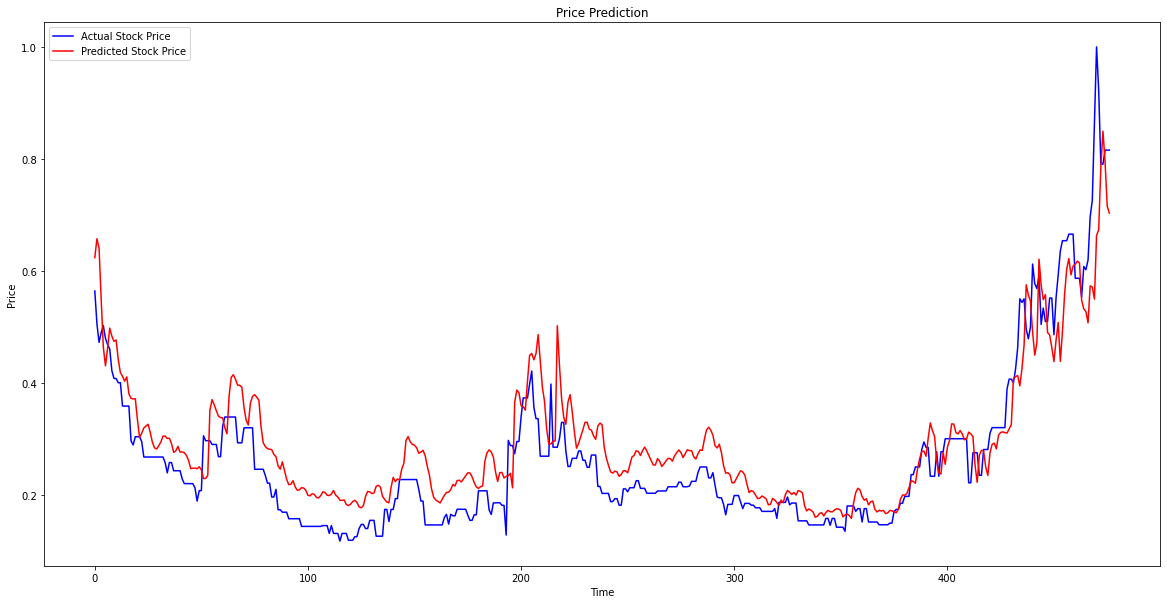

In [37]:
testY_test = np.delete(testY, np.s_[1:a], axis=1)
predicted_price_test_test = np.delete(predicted_price_test, np.s_[1:a], axis=1)

testY_test = np.reshape(testY_test, (477, 1))
predicted_price_test_test = np.reshape(predicted_price_test_test, (477, 1))
print(testY_test.shape)
print(predicted_price_test_test.shape)

plt.figure(figsize=(20,10))
plt.plot(testY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_test_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [38]:
predicted_price_test_test = np.reshape(predicted_price_test_test, (477, ))
predicted_price_test_test = scaler_target.inverse_transform(predicted_price_test_test.reshape(-1,1))

print(predicted_price_test_test, predicted_price_test_test.shape)

testY_test = scaler_target.inverse_transform(testY_test.reshape(-1,1))

print(testY_test, testY_test.shape)

[[3188.9727]
 [3304.8818]
 [3247.7063]
 [2932.6274]
 [2640.4504]
 [2526.7915]
 [2634.0183]
 [2757.7148]
 [2708.2861]
 [2676.4607]
 [2685.1392]
 [2565.2178]
 [2485.0432]
 [2462.4558]
 [2432.8123]
 [2458.7942]
 [2354.678 ]
 [2327.265 ]
 [2323.7883]
 [2324.6501]
 [2197.2302]
 [2086.714 ]
 [2114.5334]
 [2146.13  ]
 [2157.3982]
 [2168.3896]
 [2118.606 ]
 [2059.4048]
 [2024.2367]
 [2017.4724]
 [2037.0215]
 [2060.2031]
 [2095.7205]
 [2096.1526]
 [2081.4622]
 [2082.685 ]
 [2049.3064]
 [1996.8964]
 [2005.461 ]
 [2033.2202]
 [1998.1357]
 [1999.0621]
 [1994.3937]
 [1977.5999]
 [1946.5522]
 [1897.3674]
 [1899.2404]
 [1900.6046]
 [1896.0066]
 [1907.9597]
 [1889.8496]
 [1836.5221]
 [1836.1134]
 [1856.2053]
 [2253.3838]
 [2319.8613]
 [2288.8992]
 [2252.2642]
 [2218.9958]
 [2209.8389]
 [2207.5215]
 [2147.542 ]
 [2109.909 ]
 [2340.6753]
 [2455.963 ]
 [2472.2383]
 [2444.339 ]
 [2408.0222]
 [2407.4424]
 [2395.0393]
 [2271.7803]
 [2193.6953]
 [2164.1396]
 [2298.563 ]
 [2339.606 ]
 [2349.482 ]
 [2334.2236]

In [39]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(testY_test, predicted_price_test_test) 
np.sqrt(MSE)

222.87052180619494

In [40]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(testY_test, predicted_price_test_test)

179.4269443727889

예측방법

In [41]:
minX1 = np.array(dataX[0:3])
minX2 = np.array(dataX[0:4])
minX3 = np.array(dataX[0:2385])
minX4 = np.array(dataX[0:train_size])

In [42]:
predicted_price_min1 = model.predict(minX1, batch_size=a, verbose=1)
predicted_price_min2 = model.predict(minX2, batch_size=a, verbose=1) 
predicted_price_min3 = model.predict(minX3, batch_size=a, verbose=1)
predicted_price_min4 = model.predict(minX4, batch_size=a, verbose=1) 

477/477 [==============================] - 1s 2ms/step


In [43]:
predicted_price_min1[0]

array([[0.655417  ],
       [0.56645775],
       [0.4538216 ]], dtype=float32)

In [44]:
predicted_price_min2[0]

array([[0.33691382],
       [0.24142867],
       [0.1687772 ]], dtype=float32)

In [45]:
predicted_price_min3[0]

array([[0.16786608],
       [0.20725758],
       [0.22311187]], dtype=float32)

In [46]:
scaler_target.inverse_transform(predicted_price_min4[0].reshape(-1,1))

array([[3297.0466],
       [2991.6494],
       [2604.9695]], dtype=float32)